# < Deep Learning - PART3 TF2 RNNs >

# Ch 6. RNNs Workshop 3 - NLP - RNNs - IMDB : RNN & LSTM
2021/10/01

>**[ Reference ] :**
> + François Chollet, **Deep Learning with Python**, Chapter 6, Section 2, Manning, 2018.
>
>    [Code] : https://github.com/fchollet/deep-learning-with-python-notebooks
>
>
> + Wikipedia, **Recurrent neural network** https://en.wikipedia.org/wiki/Recurrent_neural_network
> + Wikipedia, **Long short-term memory** https://en.wikipedia.org/wiki/Long_short-term_memory
>
>
>+ Andrej Karpathy blog,
“**The Unreasonable Effectiveness of Recurrent Neural Networks**”
https://karpathy.github.io/2015/05/21/rnn-effectiveness/

---

#### [1. A first recurrent layer in `tf.keras`](#RNN)
#### [2. A concrete LSTM example in `tf.keras`](#LSTM)
--------

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

<a id='RNN'></a>
## 1. A first recurrent layer in `tf.keras`

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [2]:
from tensorflow.keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

**2021/09/01 CSCGroup#**

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(16))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
Total params: 320,784
Trainable params: 320,784
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\appcl\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\appcl\anaconda3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense

from tensorflow.keras import regularizers

model = Sequential()
model.add(Embedding(max_features, 8))
model.add(SimpleRNN(32, return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001),
                    bias_regularizer=None))
model.add(SimpleRNN(32, return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001),
                    bias_regularizer=None))
model.add(SimpleRNN(32, return_sequences=True,
                    kernel_regularizer=regularizers.l2(0.001),
                    recurrent_regularizer=regularizers.l2(0.001),
                    bias_regularizer=None))model.add(SimpleRNN(16))  # This last layer only returns the last outputs.
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, None, 32)          1312      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 82,113
Trainable params: 82,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 22s 129ms/step - loss: 0.7441 - acc: 0.5133 - val_loss: 0.7747 - val_acc: 0.5210
Epoch 2/10
157/157 [==============================] - 22s 140ms/step - loss: 0.5775 - acc: 0.7333 - val_loss: 0.4

Let's display the training and validation loss and accuracy:

In [17]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


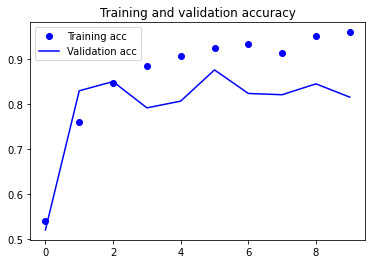

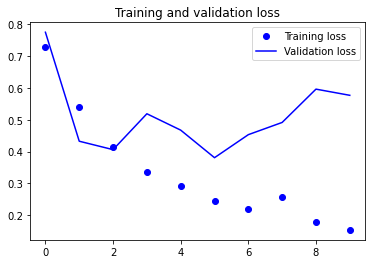

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

<a id='LSTM'></a>
## 2. A concrete LSTM example in `tf.keras`

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [22]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense

max_features = 10000
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(64, return_sequences=True,
               kernel_regularizer=regularizers.l2(0.001),
               recurrent_regularizer=regularizers.l2(0.001),
               bias_regularizer=None))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 357,281
Trainable params: 357,281
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 74s 449ms/step - loss: 0.6668 - acc: 0.6503 - val_loss: 0.4367 - val_acc: 0.8114
Epoch 2/10
157/157 [==============================] - 81s 518ms/step - loss: 0.3627 - acc: 0.8628 - val_loss: 0.3903 - val_acc: 0.8480
Epoch 3/10
157/157 [==============================] - 81s 518ms/step - loss: 0.3013 - acc: 0.8960 - val_loss: 0.3631 - val_acc: 0.8634
Epoch 4/10
157/157 [==============================] - 80s 513ms/step - loss: 0.2443 - acc: 0.9160 - val_loss: 0.4709 - val_acc: 0.8348
Epoch 5/10
157/157 [==============================] - 85s 541ms/step - loss: 0.2199 - acc: 0.9242 - val_loss: 0.3678 - val_acc: 0.8800
Epoch 6/10
157/157 [==============================] - 85s 539ms/step - loss: 0.1949 - acc: 0.9362 - val_loss: 0.4297 - val_acc: 0.8722
Epoch 7/10
157/157 [==============================] - 90s 576ms/step - loss: 0.1954 - acc: 0.9383 - val_loss: 0.4261 - val_acc: 0.8760
Epoch 8/10
157/157 [==============================] - 8

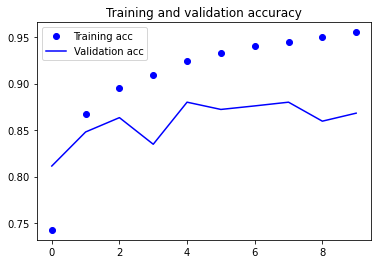

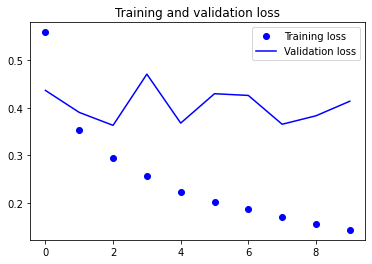

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()